# Regresión logística: Clasificación multiclase
M2U5 - Ejercicio 6

## ¿Qué vamos a hacer?
- Crear un dataset sintético para regresión logística multiclase
- Preprocesar los datos
- Entrenar el modelo sobre el subset de entrenamiento y comprobar su idoneidad
- Hallar el parámetro de regularización *lambda* óptimo por CV
- Realizar predicciones sobre nuevos ejemplos

Recuerda seguir las instrucciones para las entregas de prácticas indicadas en [Instrucciones entregas](https://github.com/Tokio-School/Machine-Learning/blob/main/Instrucciones%20entregas.md).

## Instrucciones
Una vez implementado el entrenamiento completo de un modelo de regresión logística regularizada para clasificación binaria (2 clases), vamos a repetir el mismo ejemplo para clasificación multi-clase (3+ clases).

In [1]:
import time
import numpy as np
from sklearn.utils import shuffle
from matplotlib import pyplot as plt

## Crear un dataset sintético para regresión logística multiclase

Vamos a crear un dataset sintético de 3 clases para esta implementación completa.

Para ello, crea un dataset sintético para regresión logística con término de bias y error de forma manual (para tener disponible *Theta_verd*) con una plantilla de código ligeramente diferente a la que has usado en el último ejercicio.

Para la clasificación multiclase vamos a calcular la Y de una forma diferente: Y tendrá unas dimensiones 2D de (m x clases) para representar todas las clases posibles. A esta codificación de p. ej. [0, 0, 1] para la clase 3/3 la llamamos "one-hot encoding":

- Para cada ejemplo y clase, calcula *Y* con el sigmoide con *Theta_verd* y *X*.
- Transforma los valores de *Y* para que sean `0` o `1` según el valor máx. del sigmoide de todas las clases.
- Por último, transforma en 1 el valor de la clase con un valor máx. del sigmoide, y en 0 los valores del resto de clases, con un ndarray final por cada ejemplo.

Para introducir un término de error, recorre todos los valores de *Y* y, con un porcentaje de error aleatorio, modifica la clase de dicho ejemplo a una clase aleatoria.

*NOTA:* Investiga cómo se podría conseguir un dataset sintético para clasificación multiclase con métodos de Scikit-learn.

### Implementa la función de activación sigmoide

Copia tu función de ejercicios anteriores:

In [2]:
# TODO: Implementa la función sigmoide
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Crea el dataset sintético:

In [3]:
# TODO: Genera un dataset sintético con término de bias y error de forma manual
# Ya que vamos a entrenar tantos modelos, generamos un dataset "pequeño" para que se entrenen rápido
# Si lo necesitas, puedes hacerlo más pequeño aún, o si quieres más precisión y un reto más real, ampliarlo
m = 1000
n = 2
clases = 3
error = 0.15

# Genera un array 2D m x n con valores aleatorios entre -1 y 1
# Insértale el término de bias como una primera columna de 1s
X = np.random.uniform(-1, 1, size=(m, n))
X = np.hstack([np.ones((m, 1)), X])


# Genera un array de theta 2D de (clases x n + 1) valores aleatorios
Theta_verd = np.random.uniform(-2, 2, size=(clases, n + 1))

# Y tendrá unas dimensiones 2D de (m x clases)
# Calcula la Y con el sigmoide y transforma sus valores en 0 o 1 y luego a one-hot encoding
Y = np.zeros((m, clases))
for i in range(m):
    sigs = np.zeros(clases)
    for c in range(clases):
        sigs[c] = sigmoid(np.dot(Theta_verd[c], X[i]))
    clase = np.argmax(sigs)
    Y[i, clase] = 1

# Para introducir un término de error, recorre todos los valores de Y y, con un % de error aleatorio, modifica
# la clase elegida de dicho ejemplo por otra clase aleatoria
# Nota: asegúrate que la otra clase aleatoria que representa el error es diferente a la original

for j in range(m):
    if np.random.rand() <= error:
        clase_original = np.argmax(Y[j])
        clases_posibles = [c for c in range(clases) if c != clase_original]
        clase_err = np.random.choice(clases_posibles)
        Y[j] = np.zeros(clases)
        Y[j, clase_err] = 1

# Comprueba los valores y dimensiones de los vectores
print('Theta a estimar:')
print(Theta_verd)
print('\nPrimeras 10 filas y 5 columnas de X e Y:')
print(X[:10])
print()
print(Y[:10])
print('\nDimensiones de X e Y:')
print(X.shape, Y.shape)

Theta a estimar:
[[-0.95378134 -0.13561848 -1.49074259]
 [-1.93481927  1.47961057  1.91326034]
 [ 0.02447233  1.79484215  0.40044204]]

Primeras 10 filas y 5 columnas de X e Y:
[[ 1.          0.54469538  0.07195588]
 [ 1.         -0.78268874  0.34153057]
 [ 1.          0.79214014 -0.83208406]
 [ 1.          0.0409999   0.31574586]
 [ 1.          0.5314353   0.27138471]
 [ 1.         -0.55246591  0.48662313]
 [ 1.         -0.61553392  0.91189842]
 [ 1.          0.24791203 -0.95820936]
 [ 1.         -0.04909653 -0.48709865]
 [ 1.         -0.56100669 -0.98917858]]

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]

Dimensiones de X e Y:
(1000, 3) (1000, 3)


## Preprocesar los datos

Al igual que hacíamos para la regresión lineal, vamos a preprocesar los datos completamente, siguiendo los 3 pasos habituales:

- Reordenarlos aleatoriamente.
- Normalizarlos.
- Dividirlos en subsets de entrenamiento, validación y test.

### Reordenar el dataset aleatoriamente

Reordena los datos del dataset *X* e *Y*:

In [4]:

print('Primeras 10 filas y 5 columnas de X e Y:')
print(X[:10])
print(Y[:10])
print()

print('Reordenamos X e Y:')
X, Y = shuffle(X, Y, random_state=42)

print('Primeras 10 filas y 5 columnas de X e Y:')
print(X[:10])
print(Y[:10])
print()

print('Dimensiones de X e Y:')
print(X.shape)
print(Y.shape)


Primeras 10 filas y 5 columnas de X e Y:
[[ 1.          0.54469538  0.07195588]
 [ 1.         -0.78268874  0.34153057]
 [ 1.          0.79214014 -0.83208406]
 [ 1.          0.0409999   0.31574586]
 [ 1.          0.5314353   0.27138471]
 [ 1.         -0.55246591  0.48662313]
 [ 1.         -0.61553392  0.91189842]
 [ 1.          0.24791203 -0.95820936]
 [ 1.         -0.04909653 -0.48709865]
 [ 1.         -0.56100669 -0.98917858]]
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]

Reordenamos X e Y:
Primeras 10 filas y 5 columnas de X e Y:
[[ 1.          0.51118951 -0.70502725]
 [ 1.          0.67090669 -0.54703696]
 [ 1.          0.64279199 -0.33121652]
 [ 1.          0.41640336 -0.90023104]
 [ 1.          0.18203473 -0.96331346]
 [ 1.         -0.21234158  0.13643527]
 [ 1.          0.18556959  0.3626309 ]
 [ 1.         -0.54999636  0.44969527]
 [ 1.         -0.85928848  0.43027085]
 [ 1.         -0.52761897 -0.337846

### Normalizar el dataset

Implementa la función de normalización y normaliza el dataset de ejemplos *X*:

In [5]:
# TODO: Normaliza el dataset con una función de normalización

# Copia tu función de normalización utilizada en la unidad de regresión lineal
def normalize(x, mu, std):
    return (x - mu) / std

# Halla la media y la desviación típica de las características de X (columnas), excepto la primera (bias)
mu = X[:, 1:].mean(axis=0)
std = X[:, 1:].std(axis=0)

print('X original:')
print(X[:10])
print(X.shape)

print('Media y desviación típica de las características:')
print(mu)
print(mu.shape)
print(std)
print(std.shape)

print('X normalizada:')
X_norm = np.copy(X)
X_norm[:, 1:] = normalize(X[:, 1:], mu, std)
print(X_norm[:10])
print(X_norm.shape)

X original:
[[ 1.          0.51118951 -0.70502725]
 [ 1.          0.67090669 -0.54703696]
 [ 1.          0.64279199 -0.33121652]
 [ 1.          0.41640336 -0.90023104]
 [ 1.          0.18203473 -0.96331346]
 [ 1.         -0.21234158  0.13643527]
 [ 1.          0.18556959  0.3626309 ]
 [ 1.         -0.54999636  0.44969527]
 [ 1.         -0.85928848  0.43027085]
 [ 1.         -0.52761897 -0.33784695]]
(1000, 3)
Media y desviación típica de las características:
[ 0.00717598 -0.01253001]
(2,)
[0.56800872 0.5835265 ]
(2,)
X normalizada:
[[ 1.          0.88733414 -1.18674513]
 [ 1.          1.16852205 -0.9159943 ]
 [ 1.          1.11902509 -0.54613888]
 [ 1.          0.72045967 -1.52126943]
 [ 1.          0.30784518 -1.62937493]
 [ 1.         -0.38646865  0.25528452]
 [ 1.          0.31406844  0.64292009]
 [ 1.         -0.98092215  0.79212388]
 [ 1.         -1.52544218  0.7588359 ]
 [ 1.         -0.94152594 -0.55750158]]
(1000, 3)


### Dividir el dataset en subsets de entrenamiento, validación y test

Divide el dataset de *X* e *Y* en 3 subsets con el ratio habitual, 60%/20%/20%.

Si tu nº de ejemplos es mucho más alto o bajo, siempre puedes modificar este ratio por otro como 50/25/25 o 80/10/10.

In [6]:
# TODO: Divide el dataset X e Y en los 3 subsets según los ratios indicados

ratio = [60, 20, 20]
print('Ratio:\n', ratio, ratio[0] + ratio[1] + ratio[2])

r = [0, 0]
# Consejo: la función round() y el atributo x.shape pueden serte útiles
r[0] = round(m * ratio[0] / 100)
r[1] = round(m * (ratio[0] + ratio[1]) / 100)
print('Índices de corte:\n', r)


# Consejo: la función np.array_split() puede serte útil
X_train, X_val, X_test = np.split(X, r)
Y_train, Y_val, Y_test = np.split(Y, r)


print('Tamaños de los subsets:')
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

Ratio:
 [60, 20, 20] 100
Índices de corte:
 [600, 800]
Tamaños de los subsets:
(600, 3)
(600, 3)
(200, 3)
(200, 3)
(200, 3)
(200, 3)


## Entrenar un modelo inicial para cada clase

Para la clasificación multiclase, debemos entrenar un modelo diferente para cada clase. Por tanto, si tenemos 3 clases debemos entrenar 3 modelos diferentes.

Cada modelo sólo considerará los valores de la variable objetivo relativos a su clase de una forma binaria, clasificando los ejemplos como pertenecientes a su clase o no.

Para ello, sólo le proporcionaremos los valores de *Y* para dicha clase o columna. P. ej., para `Y = [[1, 0, 1], [0, 1, 0], [0, 0, 1]]`:
- *Y* para el modelo 1: `[1, 0, 0]`
- *Y* para el modelo 2: `[0, 1, 0]`
- *Y* para el modelo 3: `[0, 0, 1]`

Al igual que hacíamos en ejercicios anteriores, vamos a entrenar modelos iniciales para comprobar que nuestra implementación es correcta:
- Entrena un modelo inicial sin regularización para cada clase.
- Representa el histórico de la función de coste para comprobar su evolución para cada modelo.
- Si es necesario, modifica cualquier hiper-parámetro, como el ratio de entrenamiento, y reentrena los modelos. Usarás dichos hiper-parámetros en siguientes puntos.

Copia las celdas de ejercicios anteriores donde implementabas la función de coste y gradient descent regularizados para regresión logística y la celda donde entrenabas el modelo:

In [7]:
# TODO: Copia la celda con el descenso de gradiente para regresión logística sin regularizar y modifícala para implementar la regularización
def regularized_cost_function_logistic(X, Y, theta, lambda_):
    m = X.shape[0]
    theta = theta.reshape(-1, 1)
    Y = Y.reshape(-1, 1)

    h = sigmoid(np.matmul(X, theta))

    cost = -(1/m) * np.sum(Y * np.log(h) + (1 - Y) * np.log(1 - h))
    reg = (lambda_ / (2 * m)) * np.sum(theta[1:] ** 2)

    return float(cost + reg)


def gradient_descent_logistic_regularized(X, Y, theta, alpha, lambda_, e=1e-6, iter_=1000):
    iter_ = int(iter_)
    j_hist = []
    m, n = X.shape

    for k in range(iter_):
        h = sigmoid(np.matmul(X, theta.reshape(-1, 1)))
        grad = (1/m) * np.matmul(X.T, (h - Y.reshape(-1,1)))

        reg_term = (lambda_ / m) * theta.reshape(-1,1)
        reg_term[0] = 0

        grad += reg_term

        theta = theta - alpha * grad.flatten()

        cost = regularized_cost_function_logistic(X, Y, theta, lambda_)
        j_hist.append(cost)

        if k > 0 and abs(j_hist[-1] - j_hist[-2]) < e:
            print(f'Convergió en la iteración {k}')
            break
    else:
        print('Número máximo de iteraciones alcanzado')

    return j_hist, theta

In [8]:
# TODO: Entrena tus modelos sobre el subset de entrenamiento sin regularizar

# Crea una theta inicial con un valor dado, que puede ser el mismo para todos los modelos o no
theta_ini = np.zeros(X_train.shape[1])

print('Theta inicial:')
print(theta_ini)

alpha = 1e-1
lambda_ = 0.
e = 1e-3
iter_ = 1e3

print('Hiper-arámetros usados:')
print('Alpha:', alpha, 'Error máx.:', e, 'Nº iter', iter_)
num_clases = clases
num_feat = X_train.shape[1]

# Inicializa unas variables para almacenar el resultado de cada modelo con las dimensiones adecuadas
# Cuidado: los modelos pueden necesitar un nº de iteraciones hasta que convergen diferente
# Dale a j_train un tamaño para almacenar hasta el nº máx. de iteraciones, aunque no se rellenen todos los elementos
j_train_ini = np.zeros((num_clases, int(iter_)))
theta_train = np.zeros((num_clases, num_feat))

t = time.time()
for c in range(num_clases):
    print('\nModelo para la clase nº:', c)

    # Copia profunda de theta_ini
    theta_c = theta_ini.copy()

    y_c = Y_train[:, c]

    t_model = time.time()
    j_hist, theta_c = gradient_descent_logistic_regularized(X_train, y_c, theta_c, alpha, lambda_, e=e, iter_=iter_)

    j_train_ini[c, :len(j_hist)] = j_hist
    theta_train[c, :] = theta_c

    print('Tiempo de entrenamiento para el modelo (s):', time.time() - t_model)

print('Tiempo de entrenamiento total (s):', time.time() - t)


print('\nCoste final del modelo para cada clase:')
for c in range(num_clases):

    j_c = j_train_ini[c]
    idx_ult = np.max(np.where(j_c != 0)) if np.any(j_c != 0) else 0
    print(f'Clase {c}:', j_c[idx_ult])

print('\nTheta final del modelo para cada clase:')
print(theta_train)

Theta inicial:
[0. 0. 0.]
Hiper-arámetros usados:
Alpha: 0.1 Error máx.: 0.001 Nº iter 1000.0

Modelo para la clase nº: 0
Convergió en la iteración 76
Tiempo de entrenamiento para el modelo (s): 0.014650344848632812

Modelo para la clase nº: 1
Convergió en la iteración 72
Tiempo de entrenamiento para el modelo (s): 0.025703907012939453

Modelo para la clase nº: 2
Convergió en la iteración 71
Tiempo de entrenamiento para el modelo (s): 0.031545162200927734
Tiempo de entrenamiento total (s): 0.07256078720092773

Coste final del modelo para cada clase:
Clase 0: 0.506802084830766
Clase 1: 0.3217334410052911
Clase 2: 0.5500700357709766

Theta final del modelo para cada clase:
[[-0.66021123 -0.65080957 -0.67961776]
 [-1.52014361 -0.03364631  0.00188421]
 [ 0.35501516  0.65120842  0.66082047]]


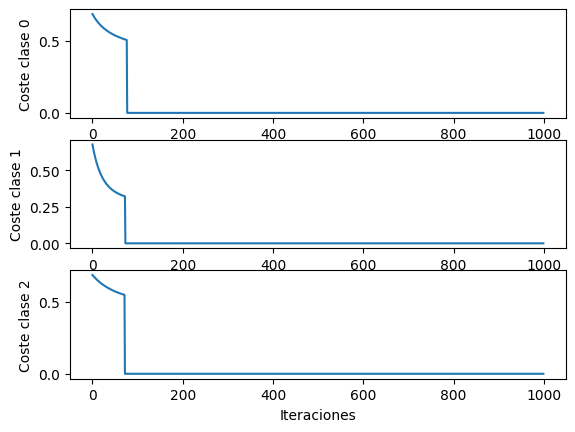

In [9]:
# TODO: Representa la evolución de la función de coste vs el nº de iteraciones para cada modelo

for c in range(clases):
    plt.subplot(clases, 1, c + 1)
    plt.xlabel('Iteraciones')
    plt.ylabel('Coste clase {}'.format(c))

    plt.plot(j_train_ini[c, :])

plt.show()

### Comprobar la idoneidad de los modelos

Revisa la precisión de tus modelos y modifica los parámetros para reentrenarlos si es necesario.

Recuerda que si tu dataset es "demasiado preciso" puedes volver a la celda original e introducir un término de error superior.

Por complejidad de una clasificación multiclase, no te pediremos en esta ocasión que compruebes si los modelos pueden estar sufriendo desviación o sobreajuste.

## Hallar el hiper-parámetro *lambda* óptimo por validación

Del mismo modo que hemos hecho en ejercicios anteriores, vamos a optimizar nuestro parámetro de regularización por validación para cada una de las clases y modelos.

Para ello, para cada clase, vamos a entrenar un modelo diferente por cada valor de *lambda* a considerar sobre el subset de entrenamiento, y evaluar su error o coste final sobre el subset de validación.

De nuevo, vamos a representar gráficamente el error de cada modelo vs el valor de *lambda* usado e implementar un código que elija automáticamente el modelo más óptimo de entre todos para cada clase.

Recuerda entrenar todos tus modelos en igualdad de condiciones, con los mismos hiper-parámetros.

Por tanto, ahora debes modificar el código de la celda anterior para no entrenar un modelo como antes sino uno por clase y por cada uno de los valores de *lambda* a considerar:

In [10]:
# TODO: Entrena un modelo por cada valor de lambda diferente sobre X_train y evalúalo sobre X_val

# Usa de nuevo un espacio logarítmico entre 10 y 10^3 de 5 elementos con valores que comiencen por un decimal no-cero 1 o 3
# Al entrenar más modelos, podemos evaluar menos valores de lambda para reducir el tiempo de entrenamiento
lambdas = np.logspace(1, 3, 5)
# Completa el código para entrenar un modelo diferente para cada clase y valor de lambda sobre X_train
# Almacena sus thetas y costes finales
# Posteriormente, evalúa sus costes totales en el subset de validación

# Almacena dicha información en los siguientes arrays
# Cuidado con sus dimensiones necesarias
j_train = np.zeros((clases, len(lambdas)))
j_val = np.zeros((clases, len(lambdas)))
theta_val = np.zeros((clases, len(lambdas), n + 1))

for c in range(clases):
    for i, lambda_ in enumerate(lambdas):
        theta_ini_c = np.zeros(n + 1)

        j_hist, theta_final = gradient_descent_logistic_regularized(X_train, Y_train[:, c], theta_ini_c, alpha, lambda_, e, iter_)

        j_train[c, i] = j_hist[-1]
        theta_val[c, i] = theta_final

        cost_val = regularized_cost_function_logistic(X_val, Y_val[:, c], theta_final, lambda_)

        j_val[c, i] = cost_val

Convergió en la iteración 65
Convergió en la iteración 52
Convergió en la iteración 37
Convergió en la iteración 27
Convergió en la iteración 24
Convergió en la iteración 72
Convergió en la iteración 72
Convergió en la iteración 72
Convergió en la iteración 72
Convergió en la iteración 72
Convergió en la iteración 59
Convergió en la iteración 44
Convergió en la iteración 27
Convergió en la iteración 14
Convergió en la iteración 6


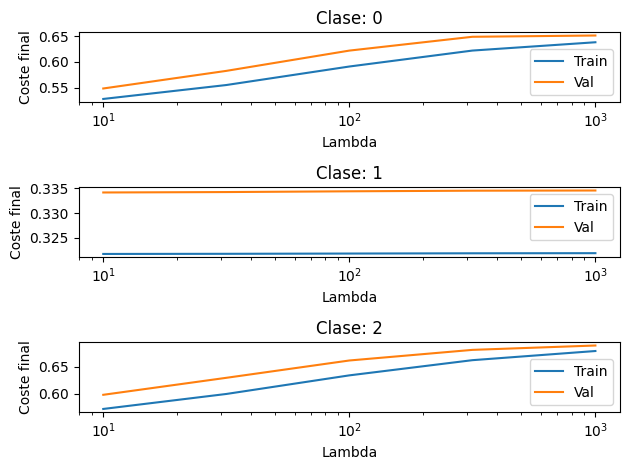

In [11]:
# TODO: Representa gráficamente el error final para cada valor de lambda con una gráfica por clase

for c in range(clases):
    plt.subplot(clases, 1, c + 1)
    plt.title('Clase: ' + str(c))
    plt.xlabel('Lambda')
    plt.ylabel('Coste final')
    plt.plot(lambdas, j_train[c], label='Train')
    plt.plot(lambdas, j_val[c], label='Val')
    plt.xscale('log')
    plt.legend()
plt.tight_layout()
plt.show()

### Escoger el mejor modelo para cada clase

Copia el código de ejercicios anteriores y modifícalo para escoger el modelo con mayor precisión sobre el subset de validación para cada clase:

In [12]:
# TODO: Escoge los modelos y valores de lambda óptimos, con el menor error sobre el subset de validación

# Itera sobre todas las combinaciones de theta y lambda y escoge los modelos de menor coste en el subset de validación para cada clase

j_final = np.zeros(clases)
theta_final = np.zeros((clases, n + 1))
lambda_final = np.zeros(clases)

for c in range(clases):
    idx = np.argmin(j_val[c])
    j_final[c] = j_val[c, idx]
    theta_final[c] = theta_val[c, idx]
    lambda_final[c] = lambdas[idx]

print('Coste final por clase:')
print(j_final)
print()

print('Lambda óptimo por clase:')
print(lambda_final)
print()

print('Theta final por clase:')
print(theta_final)



Coste final por clase:
[0.54834965 0.33417607 0.59809413]

Lambda óptimo por clase:
[10. 10. 10.]

Theta final por clase:
[[-6.15533876e-01 -5.49134039e-01 -5.74740322e-01]
 [-1.52014120e+00 -3.19437487e-02  1.48209684e-03]
 [ 3.25447957e-01  5.40119887e-01  5.49754335e-01]]


## Evaluar los modelos sobre el subset de test

Finalmente, vamos a evaluar el modelo de cada clase sobre un subset de datos que no hemos usado para entrenarlos ni para escoger ningún hiper-parámetro.

Para ello, vamos a calcular el coste o error total sobre el subset de test y comprobar gráficamente los residuos sobre el mismo.

Recuerda usar sólo las columnas de la *Y* que "vería" cada modelo, puesto que clasifica los ejemplos en función de si pertenecen a su clase o no.

In [13]:
# TODO: Calcula el error de los modelos sobre el subset de test usando la función de coste
# Utiliza la theta y lambda del modelo específico de la clase correspondiente a dicho ejemplo


j_test = np.zeros(clases)

for c in range(clases):
    j_test[c] = regularized_cost_function_logistic(X_test, Y_test[:, c], theta_final[c], lambda_final[c])

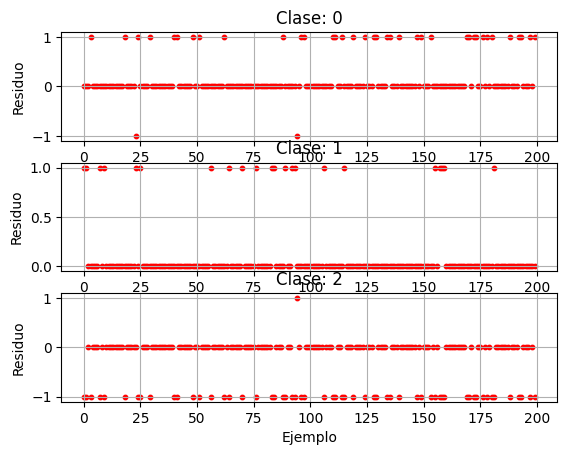

In [14]:
# TODO: Calcula las predicciones de los modelos sobre el subset de test, calcula los residuos y represéntalos

# Recuerda usar la función sigmoide para transformar las predicciones y escoger la clase según el valor máx. del sigmoide
Y_test_pred = np.zeros((X_test.shape[0], clases))

for i in range(X_test.shape[0]):
    sigs = np.zeros(clases)
    for c in range(clases):
        sigs[c] = sigmoid(np.dot(theta_final[c], X_test[i]))
    Y_test_pred[i, np.argmax(sigs)] = 1

residuos = Y_test - Y_test_pred
plt.figure(4)

for c in range(clases):
    plt.subplot(clases, 1, c + 1)
    plt.title('Clase: ' + str(c))
    plt.scatter(range(X_test.shape[0]), residuos[:, c], s=10, color= "red")
    plt.xlabel('Ejemplo')
    plt.ylabel('Residuo')
    plt.grid(True)

plt.show()

## Realizar predicciones sobre nuevos ejemplos

Con nuestros modelos ya entrenados, optimizados y evaluados, lo único que nos queda es utilizarlos realizando predicciones con nuevos ejemplos.

Para ello, vamos a:
- Generar un nuevo ejemplo, siguiendo el mismo patrón que el dataset original.
- Normalizar sus características antes de poder realizar predicciones sobre ellos.
- Generar una predicción para dicho nuevo ejemplo para cada una de las clases, para cada uno de los 3 modelos.
- Escoger la clase final como la clase con mayor valor de *Y* tras el sigmoide, aunque varios modelos predijeran `Y >= 0.0; Y = 1`.

In [15]:
# TODO: Genera un nuevo ejemplo siguiendo el patrón original, con término de bias

X_pred_sin_bias = np.random.uniform(-1, 1, size=(1, n))
X_pred = np.hstack([np.ones((1, 1)), X_pred_sin_bias])

# Para comparar, antes de normalizar los datos, usa la Theta_verd para ver cuál sería la clase real asociada
sigs = np.zeros(clases)
for c in range(clases):
    sigs[c] = sigmoid(np.dot(Theta_verd[c], X_pred[0]))
Y_verd = np.zeros(clases)
Y_verd[np.argmax(sigs)] = 1

# Normaliza sus características (excepto el término de bias) con las medias y desviaciones típicas del subset de entrenamiento
X_pred[:, 1:] = (X_pred[:, 1:] - X_train[:, 1:].mean(axis=0)) / X_train[:, 1:].std(axis=0)

# Genera una predicción para dicho ejemplo para cada modelo usando el sigmoide
Y_pred_vals = np.zeros(clases)
for c in range(clases):
    Y_pred_vals[c] = sigmoid(np.dot(theta_final[c], X_pred[0]))

# Escoge la clase final como la de mayor valor tras el sigmoide y transfórmala a un vector one-hot encoding de 0 y 1
Y_pred = np.zeros(clases)
Y_pred[np.argmax(Y_pred_vals)] = 1

# Compara la clase real asociada a dicho nuevo ejemplo y la clase predicha
print('Clase real del nuevo ejemplo y clase predicha:')
print(Y_verd)
print(Y_pred)


Clase real del nuevo ejemplo y clase predicha:
[0. 0. 1.]
[0. 0. 1.]
